Content provided under a Creative Commons Attribution license, CC-BY 4.0; code under MIT license. (c) 2014 Cameron Parvini

# The Effect of Flap Angle on Streamlines and $C_{p}$ around a Fowler-Style Airfoil Pair

Individuals alive during the early-to-mid twentieth century have often remarked that the pace of life accelerated quickly; when one considers that a person born in 1900 would be alive to see transportation move from horse and buggy to automobiles and rockets, those remarks are put into proper context. Interestingly enough, the subject of this notebook harkens back to a time before the fluid mechanics push of the 1960's and the space race, yet still finds itself relevant to modern-day aeronautics: the Fowler flap.

In 1924, Harlan D. Fowler first created the design for a variable area wing in the pursuit of higher lift. By 1927 Fowler was already testing his flap design in conjunction with airplane mechanic Stanley Crewfoot. Several years passed before the National Advisory Committee for Aeronautics (NACA for short, sound familiar?) determined that "...the Fowler flap would reduce landing speed, decrease landing and take-off runs, and improve climbing ability." $^{1}$ Fowler's crowning achievement would first fly for the Germans on their Fieseler Fi 97, followed by the Lockheed 14 Twin-Engine Airliner, and going on to accumulate an impressive list of clients: the Boeing B-29 bombers, Lockheed P-38 Ligtning, and Boeing B-17 to name just a few. The Fowler flap still remains in circulation nearly 89 years after its inception, flying on the Boeing 707, 737, 747, Lockheed Martin C-130, Northrop-Grumman E-2C, and many, many more.

To begin our analysis, lets first look at the wing geometry, courtesy of a 1976 NASA wind-tunnel study on the Fowler flap in general aviation:

<img src="NASAFowler.jpg"> <h3 align = "center" color=#CC0000>**Figure 1:** Fowler Flap Geometry</h3> 

**Image Credit:** Paulson, John W. Jr., *"Wind-Tunnel Investigation of a Fowler Flap and Spoiler for an Advanced General Aviation Wing,"* Langley Research Center, Hampton, VA 23665. June 1976. NASA TN D-8236.

As you can see, the system is relatively complex and includes a spoiler on top, vent, and nested Fowler flap mechanism that can be stored during flight when the excess lift isn't necessary. The elegance of Mr. Fowler's solution is evident not only from the geometry shown in Figure 1, but also from the longevity of the Fowler Flap.

## Getting under way

For our purposes, we will simplify the analysis by looking at a fully extended Fowler flap with a well studied airfoil: the NACA 23012. Finally, the coding can start!

Lets begin by loading our favorite libraries and the airfoil geometry. We will be utilizing two .csv files from the AeroPython course repository that have been copied into our local project directory.

In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

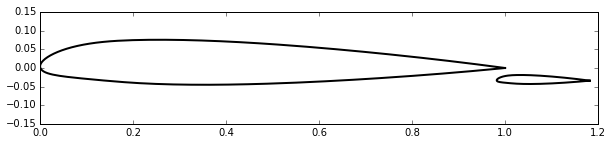

In [2]:
# Read the new values
N = 150
Nx, Ny = 100, 100

with open ('NACA23012_MainFoil.csv') as file_name:
    xm, ym = numpy.genfromtxt(file_name, dtype=float, delimiter=',', unpack=True)

with open ('NACA23012_FlapFoil.csv') as file_name:
    xf, yf = numpy.genfromtxt(file_name, dtype=float, delimiter=',', unpack=True)

pyplot.figure(figsize=(10,2))
pyplot.plot(xm, ym, xf, yf,  color='k', linestyle='-', linewidth=2)
pyplot.ylim(-0.15, 0.15);

Great, now we've got our airfoil geometry loaded and ready to go, right? Not so fast! We're gonna need a bit of math to get that rear foil to rotate exactly like we want to. The math is relatively simple, and falls out of some basic trigonometric relations given a rotation center ($x_{c},y_{c}$) and our original coordinates for the rear airfoil ($x,y$):

$$x' =\ x cos(\theta) - y sin(\theta)$$
$$y' =\ x sin(\theta) + y sin(\theta)$$

Where ($x',y'$) are our new, rotated locations given a specified angle of attack for the rear airfoil, $\theta$. In order for the transformation to work properly however, the rotation must happen about the origin (which we know isn't the case here), so we need to also shift our locations by ($-x_{c},-y_{c}$) then move the points back afterwards. Now we can write a quick little function to rotate our coordinates for us and clean up the code later.

In [3]:
def theta_transform(xf, yf, xc, yc, theta):
    """Rotates the foil about a point.
    
    Arguments
    ---------
    xf, yf -- arrays of panel endpoints.
    xc, yc -- scalar xy location of rotation center
    theta -- angle of rotation measured CCW
    
    Returns
    -------
    xfp,yfp -- arrays of rotated points.
    """   
    theta = theta * math.pi / 180.
    
    xf, yf = xf - xc, yf - yc

    xf = xf * math.cos(theta) + yf * math.sin(theta)
    yf = -xf * math.sin(theta) + yf * math.cos(theta)

    xfp, yfp = xf + xc, yf + yc
    
    return xfp, yfp

Wonderful! Let's go ahead and move our geometry and then plot the new, rotated airfoil.

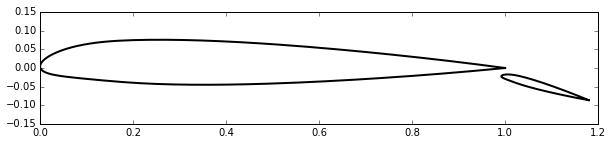

In [4]:
xc, yc = 1.03, -0.054
theta = 20.

xf, yf = theta_transform(xf, yf, xc, yc, theta)

pyplot.figure(figsize=(10,2))
pyplot.plot(xm, ym, xf, yf,  color='k', linestyle='-', linewidth=2)
pyplot.ylim(-0.15, 0.15);

Just like that, we have a proof of concept for our rotation function! This will prove very useful later.

There are 150 panels on each airfoil, giving a grand total of 300 panels that we need to consider in the flow. A novice fluid dynamicist might say, "I thought our beloved Principle of Superposition meant that we could simply pass each airfoil through our legacy code from Lesson 10 and 11? Why would we need to pass all of our panels through at once?"

A fair question, but consider this: we learned that our fundamental singularities like the vortex and doublet have an effect on points in the flow both near and far. If we were to simply exclude the panels from the flap airfoil in our analysis of the main airfoil, we would be leaving out a _huge_ effect! The source and vortex sheet from our panel method would remain uncompensated on the first airfoil, and in effect each airfoil would be blind to the other! Our values for the circulation and source strength on each panel would be totally wrong in this case. In effect, we need one **huge** linear system of equations describing the effect of each panel on every other in the flow, compensating for the source and vortex strengths, and making sure to satisfy the Kutta condition on the trailing edge (TE) of both airfoils.

Now, using a modified form of our legacy code from Lesson 11 we can read in our ($x,y$) coordinates as our panel endpoints. Let's go ahead and bring some useful pieces into our current problem! First, our panel class:

In [5]:
class Panel:
    """Contains information related to one panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'extrados'
        else:
            self.loc = 'intrados'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

Then, our Freestream class:

In [6]:
class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf, alpha):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        u_inf -- Farfield speed (default 1.0).
        alpha -- Angle of attack in degrees (default 0.0).
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

...and finally, our new form of the define_panels() function!

In [7]:
def define_panels(x, y, N):
    """Discretizes the geometry into panels using input arrays for the ends of the panels.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the panel endpoints.
    N - number of panels.
    
    Returns
    -------
    panels -- Numpy array of panels.
    """
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    
    for i in xrange(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

We're well underway already with the code, but there are still a few pieces remaining. We need our source-vortex panel method functions to integrate, build our $\vec{b}$ array, get our tangential velocity $v_{t}$, further build our pressure coefficients, and then finally a plottable velocity grid. Beware, functions ahead!

In [8]:
def integral(x, y, panel, dxdz, dydz):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    dxdz -- derivative of x in the z-direction.
    dydz -- derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    def func(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz 
                  + (y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2 
                   + (y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

Before we use our build_rhs() function, we need to make sure that it can deal with the fact that we're going to have $\it{two}$ $\gamma$ values in the flow. We know that the circulation will be a constant along an airfoil based on the definition of our panel method, but extending it to two bodies requires the possibility of different values of $\gamma$ for each body, and additionally two Kutta conditions! Let's see how we can do that:

In [9]:
def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    
    Returns
    -------
    b -- 1D array ((N+2), N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    b[N] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[(N/2)-1].beta) )
    b[N+1] = -freestream.u_inf*( math.sin(freestream.alpha-panels[(N/2)].beta)
                              +math.sin(freestream.alpha-panels[N-1].beta) )
    
    return b

Wait, that's it? Yup! All we needed to do was make sure we grabbed the right indices for each TE panel pair: the first and last cell of the main airfoil array, and the first then last cell of the flap airfoil array. Simple, no?

The next slight change comes in the tangential velocity function to simplify some of the work; since we will be calculating the tangential form for the effects of each panel on one another ($A_{ij}^{t}$) in order to create the full linear system $A_{ij}$, it makes sense to pass the variable into our tangential velocity function to save a bit of time.

In [10]:
def get_tangential_velocity(panels, freestream, gamma, At):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma -- circulation density.
    At -- Tangential form of the Aij matrix; Simply the source matrix with the
          vortex array added to the side.
    """
    N = len(panels)
    
    var = numpy.append([panel.sigma for panel in panels], gamma)
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(At, var) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

Wonderful! We're so close now, we just need a couple more functions to get our $C_{p}$ and velocity field:

In [11]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [12]:
def get_velocity_field(panels, freestream, X, Y):
    """Returns the velocity field.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    X, Y -- mesh grid.
    """
    Nx, Ny = X.shape
    u, v = numpy.empty((Nx, Ny), dtype=float), numpy.empty((Nx, Ny), dtype=float)
    
    for i in xrange(Nx):
        for j in xrange(Ny):
            u[i,j] = freestream.u_inf*math.cos(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 1, 0) for p in panels])
            v[i,j] = freestream.u_inf*math.sin(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 0, 1) for p in panels])
    
    return u, v

In [13]:
def source_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
    
    return A

Wow, that was a mouthful (or a page-ful, at least!). In order to move forward, we're going to need one last function to tie everything together: our build_matrix function. Since we will be dealing with two bodies in the flow, we will need to create a matrix $A_{ij}$ that is (N+2)x(N+2) in size (which I'm sure you already know from reading the function descriptions above!). These extra two equations are the Kutta conditions on each airfoil, taking the form:

$$
U_{t,1} =\ - U_{t,N_{main}}$$
$$
U_{t,N_{main}+1} =\ - U_{t,N}
$$

Where $N_{main}$ is the number of points on the main airfoil, and $N = N_{main} + N_{flap}$. Utilizing this information, we can re-write our matrix forms of the normal and tangential velocity to express them in terms of the two bodies. From the Lesson 11 assignment:

$$
U^n_i = b^n_i + 
\left[\begin{smallmatrix}A^n_{i1}\cdots A^n_{iN_{main}}\end{smallmatrix}, \sum_{j=1}^{N_{main}}B^n_{ij}, \sum_{j=N_{main+1}}^{N}B^n_{ij}\right]
\left[\begin{smallmatrix}\sigma_1 \\ \vdots \\ \sigma_N \\ \gamma_a \\ \gamma_b\end{smallmatrix}\right]
$$
$$
U^t_i = b^t_i + 
\left[\begin{smallmatrix}A^t_{i1}\cdots A^t_{iN_{main}}\end{smallmatrix}, \sum_{j=1}^{N_{main}}B^t_{ij}, \sum_{j=N_{main}+1}^{N}B^t_{ij}\right]
\left[\begin{smallmatrix}\sigma_1 \\ \vdots \\ \sigma_N \\ \gamma_a \\ \gamma_b\end{smallmatrix}\right]
$$

This means that our vortex arrays will each be (Nx1) arrays containing partial summations over the $B_{ij}$ matrix. The Kutta conditions will follow a similar form, except each will be an (1x(N+2)) array. For the first row (representing the main airfoil): 

$$[\begin{smallmatrix}-(A^t_{11}+A^t_{N_{main}1})\cdots -(A^t_{1N} + A^t_{N_{main}N}), -\sum_{j=1}^{N_{main}}(B^t_{1j}+B^t_{N_{main}j}), -\sum_{j=1}^{N_{main}}(B^t_{N_{main+1}j}+B^t_{Nj})\end{smallmatrix}]$$

Notice now that we're summing only over the first half of the columns in the first Kutta condition, corresponding to the main airfoil. Similarly, the second Kutta condition is:

$$[\begin{smallmatrix}-(A^t_{N_{main+1}1}+A^t_{N1})\cdots -(A^t_{N_{main}N} + A^t_{NN}), -\sum_{j=N_{main+1}}^{N}(B^t_{1j}+B^t_{N_{main+1}j}), -\sum_{j=N_{main+1}}^{N}(B^t_{N_{main+1}j}+B^t_{Nj})\end{smallmatrix}]$$

These arrays for the Kutta conditions fall out of the math carried out during our in-class derivation exercise. Two critical relations between the $B_{ij}$ and $A_{ij}$ matrices come from the trigonometric sines and cosines used to find the normal and tangential components. In essense:

$$B_{ij}^{n} = -A_{ij}^{t}$$
$$B_{ij}^{t} = A_{ij}^{n}$$

We finally have everything we need to build our linear system in one go! Hold on, it's about to get mathematical:

In [14]:
def build_matrix(panels):
    """Builds the matrix of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- (N+2)x(N+2) system matrix (N is the number of panels).
    a_t -- (N)x(N+2) Aij tangential matrix for use in finding v_t
    """
    # Initialize our variables
    N = len(panels)
    ak = numpy.empty((2,N+2), dtype=float)
    a_t = numpy.zeros((N,N+2), dtype=float)
    at1, at2 = numpy.zeros((N), dtype=float), numpy.zeros((N), dtype=float)
    av = numpy.empty((N,2), dtype=float)
    A = numpy.empty((N+2,N+2), dtype=float)
    Bn = numpy.empty((N,N), dtype=float)
    numpy.fill_diagonal(Bn, 0.0)
    
    # Get our source matrix, the normal form of Aij    
    An = source_matrix(panels)
    
    # Build our Bij normal matrix
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                Bn[i,j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
    
    # Create our vortex arrays by summing across the rows of Bij normal
    for i, p_i in enumerate(panels):
        av[i,0] = numpy.sum(Bn[i,:N/2])
        av[i,1] = numpy.sum(Bn[i,N/2:])
    
    # Build the last two columns of our Aij tangential matrix
    for i, p_i in enumerate(panels):
        at1[i] = numpy.sum(An[i,:N/2])
        at2[i] = numpy.sum(An[i,N/2:])
    
    # Our Bij normal is the same as our Aij tangential
    a_t[:N,:N] = Bn
    
    # The last two columns of Aij tangential come from Bij tangential,
    # or as we have done, from -Aij normal summations
    a_t[:,-2], a_t[:,-1] = -at1, -at2
    
    # Enforce our kutta conditions on the two airfoils by summing the
    # rows of Aij tangential corresponding to the TE panels
    ak[0,:], ak[1,:] = a_t[0,:] + a_t[N/2-1,:], a_t[N/2,:] + a_t[-1,:]
    
    # Put it all together
    A[0:N,0:N], A[0:N,N:], A[N:,:] = An, av, ak
    
    return A, a_t

## Start the fun already!

Just like that, we've got ourselves a two-body solver. The next few steps involve a couple Python tricks, so pay attention! First, let's set our initial conditions:

In [15]:
# Given
u_inf = 1.0
alpha = 0.0              # Angle of Attack for the flow
N = 150                # The number of panels on each airfoil
Nx, Ny = 50, 50          # The size of our velocity and Cp grids
steps = 4                # This is the number of different angles to simulate 

Afterwards, we'll read our geometry again (using the same variables, just to save some space).

In [16]:
with open ('NACA23012_MainFoil.csv') as file_name:
    xm, ym = numpy.genfromtxt(file_name, dtype=float, delimiter=',', unpack=True)

with open ('NACA23012_FlapFoil.csv') as file_name:
    xf, yf = numpy.genfromtxt(file_name, dtype=float, delimiter=',', unpack=True)

Then let's go ahead and set a couple useful variables for the simulation to come.

In [17]:
l_total = (numpy.max(xm)-numpy.min(xm)) + (numpy.max(xf)-numpy.min(xf))
xc, yc = 1.03, -0.054
angles = numpy.linspace(0.,30.,steps)

Now we have the total chord length of the airfoils, the rotation center for our flap, and the angles that we want to simulate the flow at! For completeness, we'll define some placeholders for the coming math.

In [18]:
# Initialize Variables
panels = numpy.empty((steps,2*N), dtype=object)
panel_main = numpy.empty((steps,N), dtype=object)
panel_flap = numpy.empty((steps,N), dtype=object)
xf_plot = numpy.empty((steps,2*N), dtype=object)
yf_plot = numpy.empty((steps,2*N), dtype=object)
u, v = numpy.empty((steps, Nx, Ny), dtype=float), \
        numpy.empty((steps, Nx, Ny), dtype=float)
cp = numpy.empty((steps, Nx, Ny), dtype=float)
accuracy = numpy.empty(steps, dtype=float)
lift, drag = numpy.empty(steps, dtype=float),numpy.empty(steps, dtype=float)
cl = numpy.empty(steps, dtype=float)

We're creating 2D arrays for the panel arrays because we plan to flex our python animation skills at the end - don't be afraid! Now that we've got that out of the way, let's go ahead and get back to basics: loading the airfoil and rotating our flap! In order to animate our $C_{p}$ and streamlines later, we'll need to step through our angles array using the handy enumerate function.

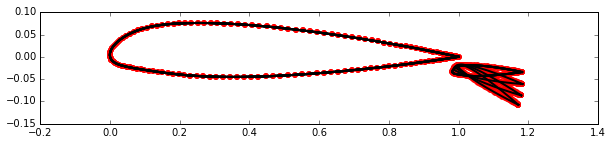

In [19]:
# Set up the geometry
pyplot.figure(figsize=(10,2))
val_x, val_y = 0.5, 0.5
x_min, x_max = xm.min(), xf.max()
y_min, y_max = yf.min(), ym.max()
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

for i, theta in enumerate(angles):     
        
    x, y = theta_transform(xf, yf, xc, yc, theta)
    
    pyplot.plot(xm, ym,  color='k', linestyle='-', linewidth=2);
    pyplot.plot(xf, yf,  color='k', linestyle='-', linewidth=2);
    panel_main[i] = define_panels(xm, ym, N)
    panel_flap[i] = define_panels(x, y, N)
    panels[i] = numpy.concatenate((panel_main[i], panel_flap[i]), axis = 0)
    
    # Check the data points
    pyplot.plot(xm, ym, x, y,  color='k', linestyle='-', linewidth=2)
    
    pyplot.scatter([panel.xa for panel in panel_main[i]], [panel.ya for panel in panel_main[i]], color='r');
    pyplot.scatter([panel.xa for panel in panel_flap[i]], [panel.ya for panel in panel_flap[i]], color='r');
    pyplot.grid()
    
    xf_plot[i], yf_plot[i] = [panel.xa for panel in panels[i,:]], [panel.ya for panel in panels[i,:]]

Pretty cool, right? It's nice to see things starting to come together! The key difference between the analysis performed in notebook 11 and this one is the idea of thinking in more dimensions. We have created arrays of arrays here (2D matrices, to most!), and we're accessing each one when we want to view a particular flow. We've also got arrays of matrices (3D matrices) for our plotting variables, and it can be tough to keep track of everything. The important thing is to find a way of visualizing the data that you understand, so you can see what data you are accessing in your mind's eye!

Moving past lofty talk of higher order data structures, we can really start the math (about time)...

In [20]:
# Create the freestream
freestream = Freestream(u_inf, alpha)

# Get our scaling right for the plots
val_x, val_y = 2.0, 4.0
x_min, x_max = numpy.min( [panel.xa for panel in panel_main[0]] ), numpy.max( [panel.xa for panel in panel_flap[0]] )
y_min, y_max = numpy.min( [panel.ya for panel in panel_flap[0]] ), numpy.max( [panel.ya for panel in panel_main[0]] )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

# Create our meshgrid for the plots
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, Nx), numpy.linspace(y_start, y_end, Ny))

...and now to throw our legacy code into a handy for loop. Beware, this is going to take a bit to run. Take this time to really think about what we've done so far: how could you speed up the calculations that are occurring? Where do you think the biggest bottleneck is? As with any code, there is always room for improvement; in this way, the method of open-source learning truly shines!

In [21]:
# Run through all the simulations
for i in xrange(steps):
    A, At = build_matrix(panels[i])
    b = build_rhs(panels[i], freestream)
    variables = numpy.linalg.solve(A,b)

    for j, panel in enumerate(panels[i]):
        panel.sigma = variables[j]

    gamma = variables[-2:]
    get_tangential_velocity(panels[i], freestream, gamma, At)
    get_pressure_coefficient(panels[i], freestream)

    u[i,:,:], v[i,:,:] = get_velocity_field(panels[i], freestream, X, Y)
    cp[i,:,:] = 1.0 - (u[i,:,:]**2+v[i,:,:]**2)/freestream.u_inf**2
    panel_main[i,:], panel_flap[i,:] = panels[i,0:N], panels[i,N:]

Well that took long enough! Now let's take a peek at what the last iteration looks like, with the flap fully turned.

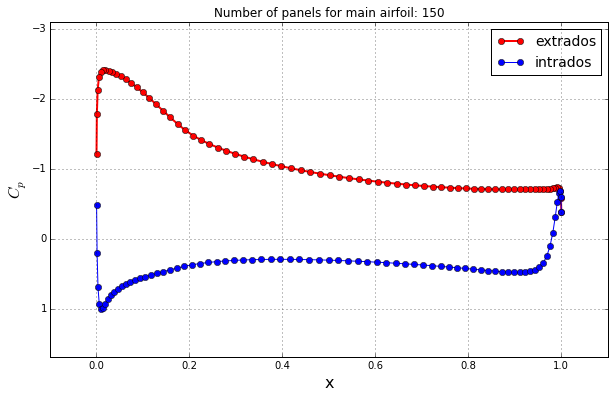

In [22]:
view = -1
val_x, val_y = 0.10, 0.20
x_min, x_max = numpy.min( [panel.xa for panel in panel_main[view,:]] ), numpy.max( [panel.xa for panel in panel_main[view,:]] )
cp_min, cp_max = numpy.min( [panel.cp for panel in panel_main[view,:]] ), numpy.max( [panel.cp for panel in panel_main[view,:]] )
x_start, x_end = x_min - val_x * (x_max-x_min), x_max + val_x * (x_max-x_min)
y_start, y_end = cp_min - val_y * (cp_max-cp_min), cp_max + val_y * (cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panel_main[view,:] if panel.loc == 'extrados'], 
         [panel.cp for panel in panel_main[view,:] if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panel_main[view,:] if panel.loc == 'intrados'], 
         [panel.cp for panel in panel_main[view,:] if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['extrados', 'intrados'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels for main airfoil: %d' % N);

Just as we expect, the upper surface has a lower $C_{p}$ value that the lower, and the ends meet (roughly). What about the flap airfoil?

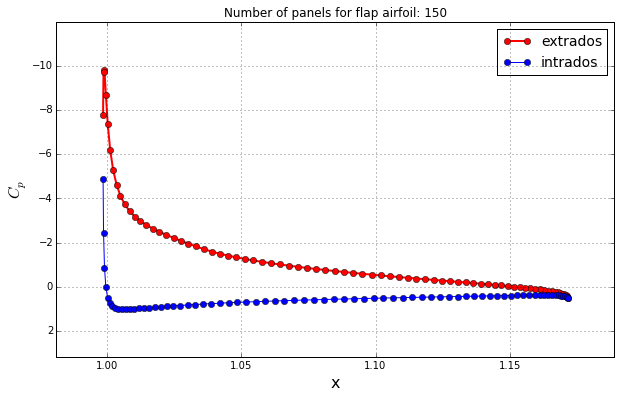

In [23]:
val_x, val_y = 0.10, 0.20
x_min, x_max = numpy.min( [panel.xa for panel in panel_flap[view]] ), numpy.max( [panel.xa for panel in panel_flap[view]] )
cp_min, cp_max = numpy.min( [panel.cp for panel in panel_flap[view]] ), numpy.max( [panel.cp for panel in panel_flap[view]] )
x_start, x_end = x_min - val_x * (x_max-x_min), x_max + val_x * (x_max-x_min)
y_start, y_end = cp_min - val_y * (cp_max-cp_min), cp_max + val_y * (cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panel_flap[view,:] if panel.loc == 'extrados'], 
         [panel.cp for panel in panel_flap[view,:] if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panel_flap[view,:] if panel.loc == 'intrados'], 
         [panel.cp for panel in panel_flap[view,:] if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['extrados', 'intrados'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels for flap airfoil: %d' % N);

This is all looking great so far! We've got an iterating panel method that can resolve all the different steps we take to turn the flap airfoil. Play around with what index we are looking at with the $view$ variable above to see the intermediate steps. As with any method of learning, there are a number of ways to communicate the information being taught; the next step for us will be to check out the streamlines around our airfoils and calculate our $C_{L}$ and accuracy. As a reminder for our accuracy calculation:

$$\sum_{i=1}^{N} \sigma_{i} L_{i} ~= 0 $$

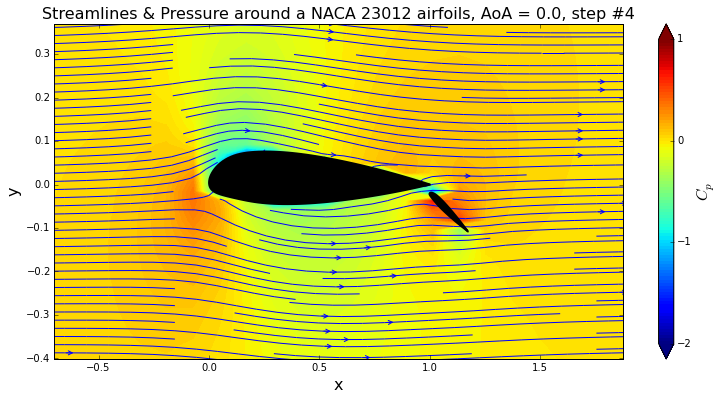

In [24]:
val_x, val_y = 0.6, 1.6
x_min, x_max = numpy.min( [panel.xa for panel in panels[view,:]] ), numpy.max( [panel.xa for panel in panels[view,:]] )
y_min, y_max = numpy.min( [panel.ya for panel in panels[view,:]] ), numpy.max( [panel.ya for panel in panels[view,:]] )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

fig = pyplot.figure(figsize=(12.75, 6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines & Pressure around a NACA 23012 airfoils, AoA = %.1f, step #%d' % (alpha, len(panel_main)), fontsize=16)
contf = pyplot.contourf(X, Y, cp[view,:,:], levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])

pyplot.streamplot(X, Y, u[view,:,:], v[view,:,:], density=2, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panel_main[view]], 
         [panel.yc for panel in panel_main[view]], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panel.xc for panel in panel_flap[view]], 
         [panel.yc for panel in panel_flap[view]], 
         color='k', linestyle='solid', linewidth=2, zorder=2);

In [25]:
# Empty the variables
accuracy[:] = 0.0
lift[:] = 0.0
drag[:] = 0.0

# Run through the panels for each step
for i in xrange(steps):
    accuracy[i] = sum([panel.sigma*panel.length for panel in panel_main[i]])
    accuracy[i] += sum([panel.sigma*panel.length for panel in panel_flap[i]])
    
    for panel in panels[i,:]:
        lift[i] -= panel.cp * panel.length * math.sin(panel.beta)
        drag[i] += panel.cp * panel.length * math.cos(panel.beta) 
    
    cl[i] = lift[i] / l_total
    
print 'Sum of source/sink strengths:', accuracy[view]
print(r'Lift coefficient: C_l = %.3f' %(cl[view]))

Sum of source/sink strengths: 0.000683692501492
Lift coefficient: C_l = 1.510


An interesting phenomenon to note involves the lift values with flap systems. What effect do you believe adding a rear airfoil to our system would have on the overall lift? How about on just the main airfoil?

We know that in order to calculate our lift we must sum across all of our panels using: $-\sum C_{p} l_{i} sin (\beta)$. When we add a flap to the flow, we aren't changing the length of the panels ( $l_{i}$ ) or the angle that each panel is inclined to the freestream ( $\beta$ ). The only variable left, $C_{p}$, $\it{does}$ in fact change based on the existence of a flap in the flow; another pair of stagnation points (from our Kutta conditions) are among several reasons that our pressure field would change. **Do you think that our total lift will increase or decrease at $\alpha = 0^\circ$ by adding the flap? Why?**

## Who needs Hollywood?

We've still got one last trick up our sleeves for displaying the data: animations! Animating a plot is a great way to show visual learners how the flow is physically changing when the fowler flap is being extended. In truth, the animation functions are not complicated to figure out once you have the hang of them. First, we'll need to load the necessary toolboxes to create our video:

In [26]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In order to create an animation, we first need to define what our initial state will be for the frame using the init() function. Because we will want to show the airfoil bodies, the streamlines, and the $C_{p}$ contours, there will have to be a blank function for each of those telling python that we want to clear those values before we begin the animation. Now let's see how it should look:

In [27]:
def init():
    ax.scatter([],[],c='k',marker='o')
    ax.scatter([],[],c='k',marker='o')
    ax.streamplot(X, Y, wipe, wipe)
    ax.contourf(X, Y, wipe)
    
    cbar = pyplot.colorbar(contf)
    cbar.set_label('$C_p$', fontsize=16)
    cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])
    
    return ax

Again, all we're saying is that the scattered points of each airfoil, the streamlines, and contours should be wiped between each frame; the colorbar, however, will remain static by referencing a handle $contf$ that is set _outside_ of our animation function.

Next, we'll build off of our initialization function to tell the animation what to draw at each time step. The first step is to clear the previous outputs, then grab the right locations for our rear airfoil. Afterwards we fill the airfoil bodies, set our plot limits, and draw our data. Easy, no? Here's one way to do it:

In [31]:
def animate(frame):
    
    ax.cla()
    
    xf = xf_plot[frame,:]
    yf = yf_plot[frame,:]
    
    ax.fill([panel.xc for panel in panel_main[frame]], 
         [panel.yc for panel in panel_main[frame]], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
    ax.fill([panel.xc for panel in panel_flap[frame]], 
         [panel.yc for panel in panel_flap[frame]], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
    
    ax.set_xlim(x_start/2., x_end/1.5)
    ax.set_ylim(y_start, y_end)

    contf = ax.contourf(X, Y, cp[frame,:,:], levels=numpy.linspace(-2, 1, 100), extend='both')
    ax.streamplot(X, Y, u[frame,:,:], v[frame,:,:], density=3, linewidth=1, arrowsize=1, arrowstyle='->', color = 'k')        
    
    return ax

Exciting stuff! Now we have the power to animate our discrete steps in a movie, and show everyone what we're made of. Let's get to it! 

**Note:** Due to the size of the animation videos, the next cell has not been rendered for storage on Github. Download your own copy of the notebook to run it and see the video!

In [ ]:
# Animate
wipe = numpy.zeros_like(X)
fig = pyplot.figure(figsize=(12,6))
ax = pyplot.axes();

ax.set_xlabel(r'X Position [m]')
ax.set_ylabel(r'Y Position [m]')
fig.suptitle(r'Animation of Streamlines & Pressure around NACA 231012, AoA = %.1f' %(alpha), fontsize=16)

anim = animation.FuncAnimation(fig, animate, steps,\
                               init_func = init, interval=150)
display_animation(anim, default_mode='reflect')

## Dig Deeper

Woah, there's something strange going on with the rear airfoil...what do you think is happening? Is there any way to avoid it with the source/vortex sheet panel method?

When we looked at the NASA drawing in Figure 1, it was clear that the flap was intended to be stored in the main airfoil during flight. How could we implement that function into the code above? Where would we need to make changes?

### Take the next step

<img src="theta_20_plots.jpg"> <h3 align = "center" color=#CC0000> **Figure 2:** Fowler Flap Experimental Data </h3>

**Image Credit:** Paulson, John W. Jr., *"Wind-Tunnel Investigation of a Fowler Flap and Spoiler for an Advanced General Aviation Wing,"* Langley Research Center, Hampton, VA 23665. June 1976. NASA TN D-8236. pp 27. 

In Figure 2 you will find plots for $C_{D}$ and $C_{L}$ from the NASA technical note, page 27 (figure 8). This study was performed with the flap at $\theta = 20^{\circ}$ angle of attack, for different freestream angles of attack, $\alpha$. Go ahead and rework the notebook code provided to loop over a set of $\alpha$ values instead of $\theta$; where does our new multi-body panel method diverge from the eqperimental results?

We hope you had some fun with this notebook, and learned a thing or two along the way!

## Citations

http://socialarchive.iath.virginia.edu/xtf/view?docId=fowler-harlan-davey-1895--cr.xml

Paulson, John W. Jr., *"Wind-Tunnel Investigation of a Fowler Flap and Spoiler for an Advanced General Aviation Wing,"* Langley Research Center, Hampton, VA 23665. June 1976. NASA TN D-8236.



In [30]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling();